In [1]:
import os
import cv2
from Astar import get_AStarPlanner
import apriltag
import numpy as np
from utils import *
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# 更新img图像的函数
def updateImage():
    orig_img_path = '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'
    ! fswebcam  --no-banner --save {orig_img_path} -d /dev/video0 2
    img = Image.open(orig_img_path)
    return img

In [3]:
# function 1 计算Y方向的机器人世界坐标y_rob

def XY_Robot():
    # 实例化检测器并检测Apriltag
    img = updateImage()
    img = np.array(img)
#     img = cv2.imread('1.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    options = apriltag.DetectorOptions(families='tag36h11',)
    detector = apriltag.Detector(options)
    tags = detector.detect(gray)
#     print(tags)
    cnt = 0
    while len(tags) == 0 and cnt < 5:
        img = updateImage()
        img = np.array(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        tags = detector.detect(gray)
        cnt += 1
        if cnt == 5:
            run_action('turn003L')
            wait_req()
            cnt = 0
    
        
#     print(tags)
    # 获取pos和corners的代码
    tag_positions = load_tag_pos() 

    # 获取pos和corners的代码
    tag_num = len(tags)
    for n, tag in enumerate(tags):
#         print("debug here::",tag.tag_id)
#         if tag.tag_id > 41:
#             continue
        # 使用tag.id访问坐标，tag_positions的定义见前面，pos的形状为[4, 3]，分别代表已知的四个顶角在空间中的x,y,z三个坐标分量
        pos = tag_positions[str(tag.tag_id)]
#         print(pos)
        # 四个顶角在图片中的像素位置(形状为[4, 2]，分别代表四个顶角的像素空间坐标) 
        corners = np.array(tag.corners)
#         print(corners)
    # 2D坐标
    ImgPoints = corners
    # 3D坐标
    WorldPoints = pos
    # 内参矩阵
    fx = 192.0513
    fy = 194.1294
    cx = 311.9018
    cy = 233.6934
    intrinsic_matrix =  np.array([[fx,0,cx],
                              [0,fy,cy],
                              [0,0,1]],dtype = np.float64)
    # 畸变系数
    distCoeffs = np.array([0.2683,-0.2053,0,0])
    # 求解R和T的值
    retval, R, T = cv2.solvePnP(WorldPoints,ImgPoints,intrinsic_matrix,distCoeffs)
    rotM = cv2.Rodrigues(R)[0]
    cameraPosition = -np.matrix(rotM).T * np.matrix(T)
    # R矩阵的第三行
    direction = np.matrix(rotM)[2]
    #
    # print("朝向::",direction)
    x_robot = cameraPosition[0]
    y_robot = cameraPosition[1]
    
    dirXY = direction[:,:2]
    normdir = dirXY / np.linalg.norm(dirXY)
    # 使用numpy.tolist()转化为int类型
    return y_robot.tolist()[0][0],x_robot.tolist()[0][0],normdir

In [17]:
# 写一个固定转角的函数
def rotate_to_balance(zero):
    '''
    input:
    zero,角度的基准
    output:
    None.将机器人转为X轴正方向
    '''
    _,_,dirs= XY_Robot()
    theta = angle(dirs)

    # 设置一个物理上的零点,可供机器人调参数
    distance = theta - zero
    if distance > 180:
        distance -= 360
    if distance < -180:
        distance += 360

    # 优化版了rotate函数,对于转弯过大的情况单独处理
    if abs(distance) > 90:
        print("distance is too large:let's turn a big angle!")
        if distance > 0:
            run_action('turn010L')
            wait_req()
            run_action('turn010L')
            wait_req()
        else:
            run_action('turn010R')
            wait_req()
            run_action('turn010R')
            wait_req()
    if abs(distance) > 30:
        print("distance is too large:let's turn a big angle!")
        if distance > 0:
            run_action('turn010L')
            wait_req()
        else:
            run_action('turn010R')
            wait_req()
    # 设定阈值位5度
    while abs(distance) > 5:
        if distance > 0:
            run_action('turn001L')
        if distance < 0:
            run_action('turn001R')
        _,_,dirs= XY_Robot()
        theta = angle(dirs)
        distance = theta - zero
        print("Adjusting angle: theta=",theta)
        print("Target angle:",zero)

    # 最后再微调一下
    if distance > 0.5:
        run_action('turn001L')
    if distance < -0.5:
        run_action('turn001R')
    print("Adjusting angle: theta=",theta)
    return 0

In [18]:
# 合并操作
def merge(rx,ry):
    # 如果大于三个点,判断是否为直线
    if len(rx) >= 3 or len(ry) >= 3:
        if (rx[1] - rx[0]) * (ry[2] - ry[1])==(rx[2] - rx[1]) * (ry[1] - ry[0]):
            return True
    return False

In [19]:
# 获得下一个点的二维坐标，并移动
def move_to_next(next_loction_X, next_loction_Y,threshold=10):
    Y,X,direction = XY_Robot()
    # 转向
    move_dir = np.array([[next_loction_X-X, next_loction_Y-Y]])
    distance = np.linalg.norm(move_dir)
    norm_move_dir = move_dir / np.linalg.norm(move_dir)
    print("norm_move_dir = ",norm_move_dir)

    while distance > threshold:
        # 确定目标角度
        target_theta = angle(norm_move_dir)
        print('目标角度是：',target_theta)
        print('目标位置是:',next_loction_X, next_loction_Y)
        rotate_to_balance(target_theta)
        print('已调节至目标角度,前进！！！')
        wait_req()
        run_action('fastForward03')
        wait_req()
        Y,X,direction = XY_Robot()
        print('现在位置是:',X, Y)
        move_dir = np.array([[next_loction_X-X, next_loction_Y-Y]])
        distance = np.linalg.norm(move_dir)
        norm_move_dir = move_dir / np.linalg.norm(move_dir)
        print("norm_move_dir = ",norm_move_dir)
    return 0

In [24]:
Y,X,direction = XY_Robot()
print("Robot的X坐标为:",X)
print("Robot的Y坐标为:",Y)
print("朝向为:",direction)
theta = angle(direction)
print("角度为:",theta)

--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
Robot的X坐标为: 242.29624103532998
Robot的Y坐标为: 52.29014267941783
朝向为: [[-0.96454147 -0.26393134]]
角度为: [[-164.69608637]]


In [21]:
next_loction_X,next_loction_Y = 150,200
print('现在的X,Y = ',X,Y)
move_dir = np.array([[next_loction_X-X, next_loction_Y-Y]])
distance = np.linalg.norm(move_dir)
norm_move_dir = move_dir / np.linalg.norm(move_dir)
print("norm_move_dir = ",norm_move_dir)
target_theta = angle(norm_move_dir)
print('target theta = ',target_theta)

现在的X,Y =  269.63767015762465 138.262439884393
norm_move_dir =  [[-0.8886537  0.4585789]]
target theta =  [ 152.70375056]


In [22]:
XY = [[230,120], [230,170], [180,170], [130,170], [80,170], [30,170], [20, 180]]
for xy in XY:
    move_to_next(xy[0],xy[1])

--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
norm_move_dir =  [[-0.91296735 -0.40803262]]
目标角度是： [-155.91798275]
目标位置是: 230 120
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x

--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
Adjusting angle: theta= [[-149.64225044]]
Target angle: [-155.91798275]
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
test_read b'\xff'

Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
Adjusting angle: theta= [[ 20.33983357]]
Target angle: [ 126.76681572]
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing J

Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
Adjusting angle: theta= [[-112.92428694]]
Target angle: [ 126.76681572]
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing 

Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- P

Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
^C
select: Interrupted system call
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Error selecting input 0
VIDIOC_S_INPUT: Device or resource busy
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!


KeyboardInterrupt: 

In [ ]:
move_to_next(150,150)

--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
norm_move_dir =  [[-0.10938885 -0.99399903]]
目标角度是： [-96.27761774]
目标位置是: 150 150
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x0

Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
Adjusting angle: theta= [[-8.63593982]]
Target angle: [-96.27761774]
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPE

read REQ finished!
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
read REQ finished!
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.

UnboundLocalError: local variable 'child' referenced before assignment

In [19]:
run_action('fastForward03')

test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!


min_x: 0
min_y: 0
max_x: 294
max_y: 294
x_width: 37
y_width: 37
Find goal
[16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 136, 136, 136, 136, 136, 136, 136, 136, 144, 152, 160, 168] [16, 16, 16, 16, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200]


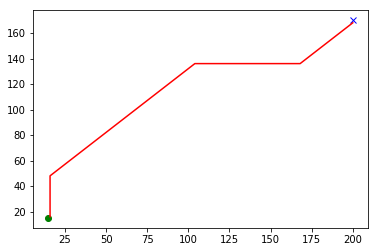

In [7]:
a_star = get_AStarPlanner(grid_size=8)
sx = 15
sy = 15
tx = 170
ty = 200
rx, ry = a_star.planning(sx, sy, tx, ty)
plt.plot(sy, sx, "og")
plt.plot(ty, tx, "xb")
plt.plot(ry, rx, "-r")
print(rx,ry)

In [19]:
a = merge(rx,ry)
print(a)

True


In [10]:
def Go(sx,sy,tx,ty):
    a_star = get_AStarPlanner(grid_size=8)
    rx, ry = a_star.planning(sx, sy, tx, ty)
    while len(rx) > 1 or len(ry) > 1:
        move_to_next(rx=rx,ry=ry)
        Y,X,direction = XY_Robot()
        sx,sy = int(X),int(Y)
        rx, ry = a_star.planning(sx, sy, tx, ty)
        print(rx,ry)
        
    print("到达终点!")
    return 0

--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
Robot的Y坐标为: 171.75672920070025
Robot的X坐标为: 36.204304682465995
朝向为: [[ 0.99999889 -0.00149098]]
角度为: [[-0.08542966]]


In [ ]:
Go(X,Y,35,180)

min_x: 0
min_y: 0
max_x: 294
max_y: 294
x_width: 37
y_width: 37
Find goal
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
move_dir =  [[ 11.71966951  -7.63937193]]
norm_move_dir =  [[ 0.83773783 -0.54607264]]
目标角度是： [-33.09897076]
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\

Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
Adjusting angle: theta= [[-2.37429307]]
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
Adjusting ang

KeyboardInterrupt: 

In [ ]:
move_to_next([266],[128])

In [ ]:
for i in range(3):
    run_action('Forwalk02')
    wait_req()
    run_action('turn001L')
    wait_req()

In [ ]:
# case 1:
# 起点:( , ) 终点:( , ) 中间柱子面点:( , ),( , )
# TODO:
# 1.从起点出发依次到达中间柱子面点前方,进行识别算法,如果正确,调用rush()函数按按钮
# 2.退回合适位置,开始规划到终点路线
# 3.到达终点,再调研rush()函数按按钮:或者前面按了则不按

In [ ]:
# case 2:
# 起点:( , ) 终点:( , ) 中间柱子面点:( , ),( , )
# TODO:
# 1.从起点出发依次到达中间柱子面点前方,进行识别算法,如果正确,调用rush()函数按按钮
# 2.退回合适位置,开始规划到终点路线
# 3.到达终点,再调研rush()函数按按钮:或者前面按了则不按

In [ ]:
# case 3:
# 起点:( , ) 终点:( , ) 中间柱子面点:( , ),( , )
# TODO:
# 1.从起点出发依次到达中间柱子面点前方,进行识别算法,如果正确,调用rush()函数按按钮
# 2.退回合适位置,开始规划到终点路线
# 3.到达终点,再调研rush()函数按按钮:或者前面按了则不按

In [ ]:
# case 4:
# 起点:( , ) 终点:( , ) 中间柱子面点:( , ),( , )
# TODO:
# 1.从起点出发依次到达中间柱子面点前方,进行识别算法,如果正确,调用rush()函数按按钮
# 2.退回合适位置,开始规划到终点路线
# 3.到达终点,再调研rush()函数按按钮:或者前面按了则不按
